In [1]:
using Pkg
if isfile("../Project.toml") && isfile("../Manifest.toml")
    Pkg.activate("..");
end

function printer(x::Any, verbose="")
    if verbose != ""
        println(verbose)
    end
    show(stdout, "text/plain", x)
    println("")
end

 Activating environment at `~/Programming/julia/notebook/JuliaProbo/Project.toml`


printer (generic function with 2 methods)

In [2]:
using CSV, DataFrames, Plots, Statistics, StatsBase, Random, Distributions, LinearAlgebra
using Seaborn: jointplot
gr();

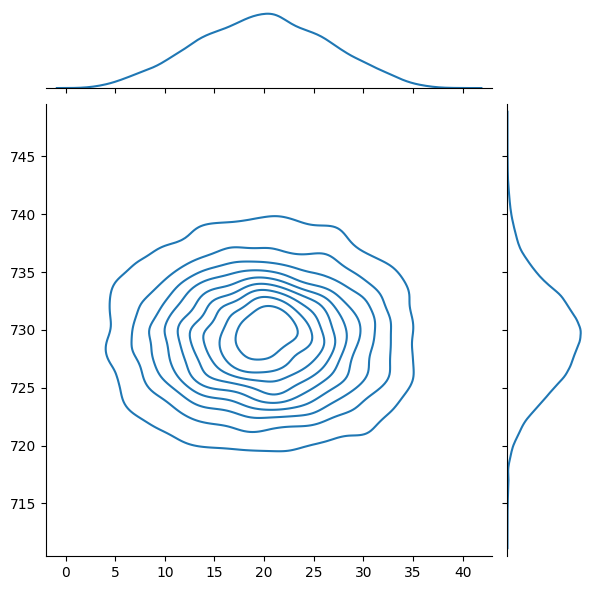

PyObject <seaborn.axisgrid.JointGrid object at 0x7f0844313470>

In [3]:
data = DataFrame(CSV.File("../sensor_data/sensor_data_700.txt"; header=["date", "time", "ir", "lidar"], types=[Float64, Float64, Float64, Float64]));

d = data[ 120000 .< data.time .< 160000, :];
d = d[:, [:ir, :lidar]]
jointplot(d.ir, d.lidar, d, kind="kde")

In [4]:
println("variance of infrared sensor: $(var(d.ir))")
println("variance of lidar measurement: $(var(d.lidar))")

diff_ir = d.ir .- mean(d.ir)
diff_lidar = d.lidar .- mean(d.lidar)

a = diff_ir .* diff_lidar
println("covariance: $(sum(a) / (size(d)[1]-1))")
df = describe(d)

variance of infrared sensor: 42.11952074692805
variance of lidar measurement: 17.702501470196577
covariance: -0.3174688165454422


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,ir,19.8604,2.0,20.0,39.0,0,Float64
2,lidar,729.312,713.0,729.0,747.0,0,Float64


In [5]:
irlidar_cov = [cov(d.ir, d.ir) cov(d.ir, d.lidar); cov(d.lidar, d.ir) cov(d.lidar, d.lidar)]

2×2 Array{Float64,2}:
 42.1195    -0.317469
 -0.317469  17.7025

In [6]:
irlidar_mean = df.mean
irlidar = MvNormal(irlidar_mean, irlidar_cov)

FullNormal(
dim: 2
μ: [19.860448708903625, 729.3121913362495]
Σ: [42.11952074692658 -0.31746881654543757; -0.31746881654543757 17.70250147019656]
)


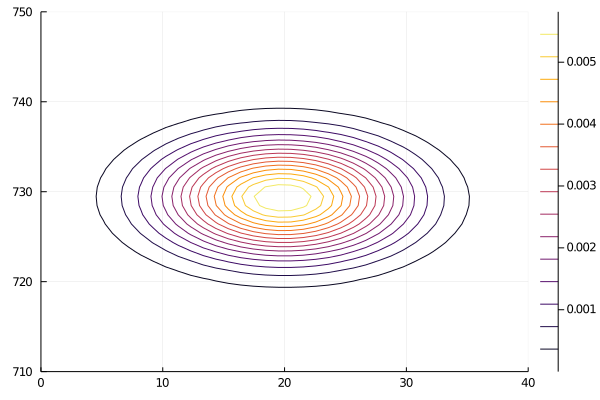

In [7]:
x = collect(range(0, 40.0, length=40))
y = collect(range(710, 750.0, length=40))
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))
Z = copy(X)
for i in 1:40
    for j in 1:40
        Z[i, j] = pdf(irlidar, [X[i, j], Y[i, j]])
    end
end
Z = [pdf(irlidar, [X[i, j], Y[i, j]]) for i in 1:40, j in 1:40]
contour(x, y, Z)

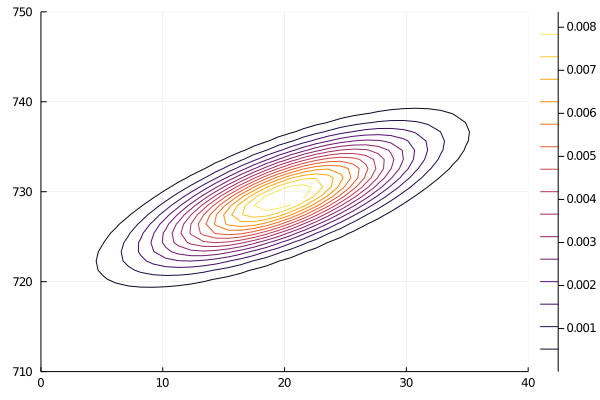

In [8]:
c = irlidar_cov + [0.0 20.0; 20.0 0.0]
tmp = MvNormal(irlidar_mean, c)
x = collect(range(0, 40.0, length=40))
y = collect(range(710, 750.0, length=40))
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))
for i in 1:40
    for j in 1:40
        Z[i, j] = pdf(irlidar, [X[i, j], Y[i, j]])
    end
end
Z = [pdf(tmp, [X[i, j], Y[i, j]]) for i in 1:40, j in 1:40]
contour(x, y, Z)

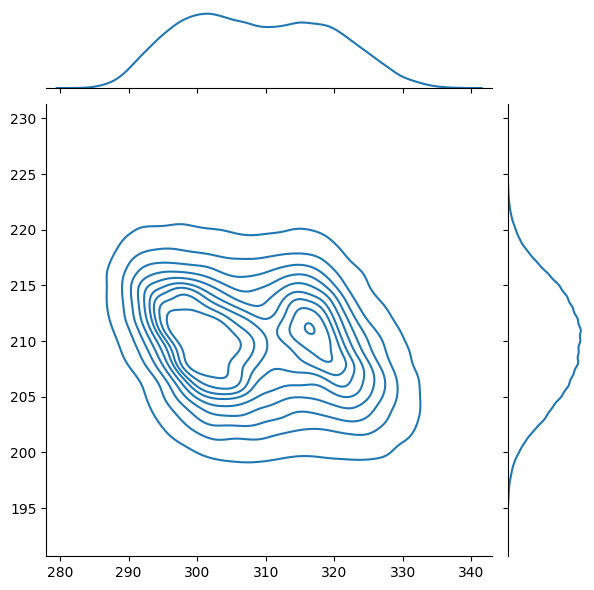

PyObject <seaborn.axisgrid.JointGrid object at 0x7f087c8e9c50>

In [9]:
data = DataFrame(CSV.File("../sensor_data/sensor_data_200.txt"; header=["date", "time", "ir", "lidar"], types=[Float64, Float64, Float64, Float64]))
d = data[!, [:ir, :lidar]]
jointplot(d.ir, d.lidar, d, kind="kde")

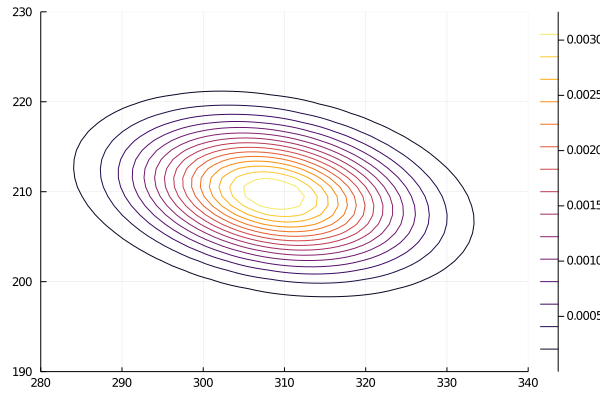

In [10]:
ir_mean = mean(data.ir)
lidar_mean = mean(data.lidar)
diff_ir = data.ir .- ir_mean
diff_lidar = data.lidar .- lidar_mean
irlidar_cov = [cov(diff_ir, diff_ir) cov(diff_ir, diff_lidar); cov(diff_lidar, diff_ir) cov(diff_lidar, diff_lidar)]
irlidar_mean = [ir_mean, lidar_mean]
irlidar = MvNormal(irlidar_mean, irlidar_cov)
x = collect(range(280, 340.0, length=60))
y = collect(range(190, 230.0, length=40))
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))
Z = zeros(40, 60)
for i in 1:40
    for j in 1:60
        Z[i, j] = pdf(irlidar, [X[i, j], Y[i, j]])
    end
end
#Z = [pdf(irlidar, [X[i, j], Y[i, j]]) for i in 1:60, j in 1:40]
contour(x, y, Z)

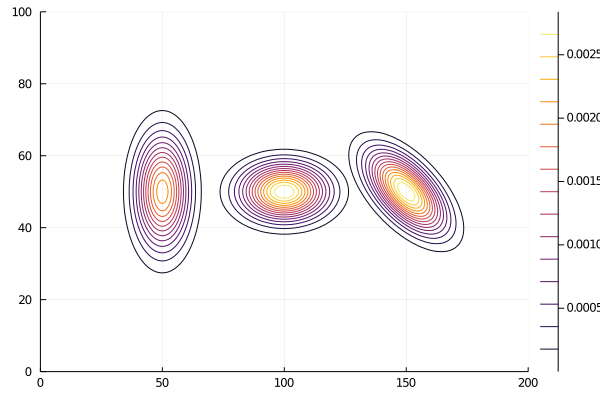

In [11]:
x = collect(range(0.0, 200, length=200))
y = collect(range(0.0, 100, length=100))
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))
a = MvNormal([50.0, 50.0], [50.0 0.0; 0.0 100.0])
b = MvNormal([100.0, 50.0], [125.0 0.0; 0.0 25.0])
c = MvNormal([150.0, 50.0], [100.0 -25.0*sqrt(3.0); -25.0*sqrt(3.0) 50.0])

p = plot()
for e in (a, b, c)
    Z = zeros(100, 200)
    for i in 1:200
        for j in 1:100
            Z[j, i] = pdf(e, [X[j, i], Y[j, i]])
        end
    end
    p = contour!(x, y, Z)
end
plot(p)

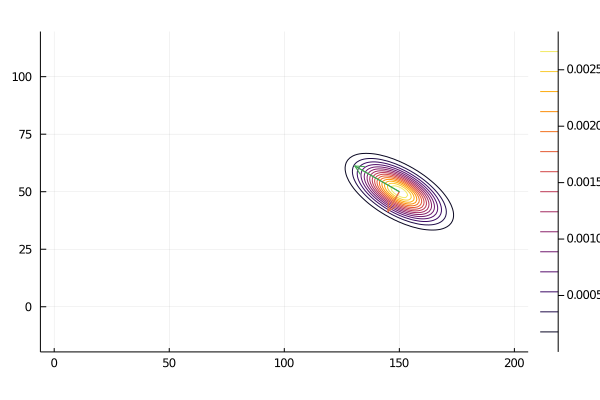

In [12]:
Z = zeros(100, 200)
for i in 1:200
    for j in 1:100
        Z[j, i] = pdf(c, [X[j, i], Y[j, i]])
    end
end
p = plot()
p = contour!(x, y, Z, aspect_ratio=:equal)
eigs = eigvals(c.Σ)
v = eigvecs(c.Σ)
v1 = 2.0 * sqrt(eigs[1]) * v[1, :]
v2 = 2.0 * sqrt(eigs[2]) * v[2, :]
p = quiver!([c.μ[1]], [c.μ[2]], quiver=([v1[1]], [v1[2]]))
p = quiver!([c.μ[1]], [c.μ[2]], quiver=([v2[1]], [v2[2]]))
plot(p)